In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import quantstats as qs
from sqlalchemy import create_engine

## Loading the Data from SQL server

In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

connect_alchemy = "postgresql+psycopg2://%s:%s@%s/%s" % (
    config['DATABASE']['USERNAME'],
    config['DATABASE']['PASSWORD'],
    config['DATABASE']['HOST'],
    config['DATABASE']['DB']
)
engine = create_engine(connect_alchemy)

In [3]:
df = pd.read_sql_query("select * from price where instrument='HINDALCO'",con=engine, parse_dates=[0], index_col='datetime')
df.head()

,close,high,low,open,volume,instrument
datetime,,,,,,
2014-01-24,114.00,115.35,113.00,113.15,5737135,HINDALCO
2014-01-27,111.10,112.70,109.30,112.00,8724577,HINDALCO
2014-01-28,113.80,115.00,109.75,110.00,4513345,HINDALCO
2014-01-29,111.75,114.75,111.15,114.50,4713458,HINDALCO
2014-01-30,108.10,110.70,107.60,110.20,5077231,HINDALCO


## Trading Strategy 

It is a simple bollinger band momentum (trend-following) strategy. It starts with computation of the bollinger bands $UB, MB, LB = BB(price, period, multiplier)$

**Trading Rules**
- Enter a long position when $price$ crosses the $UB$ from below.
- Enter a short position when $price$ crosses the $LB$ from above.
- Exit an existing long position when $price$ crosses the $UB$ from above.
- Exit an existing short position when $price$ crosses the $LB$ from below.

In [4]:
def bollinger_bands_signal(close_price:pd.Series, period:int, multiplier:float=2)->pd.DataFrame:
    """
    Computes momentum trading signals of bollinger bands 
    with a specified lookback period and multiplier.
    
    :param close_price: (pd.Series) the closing price series 
                        of the asset to trade.
    :param period: (int) the look back window size of the bollinger bands in days.
    :param multiplier: (float) the upper and lower band multiplier of the bollinger bands.
    :return: (pd.DataFrame) a dataframe containing the bollinger bands and the trading signals
    """
    bb = close_price.to_frame()
    bb['mean'] = close_price.rolling(period).mean()
    bb['std'] = multiplier*(close_price.rolling(period).std())
    bb['upper_band'] = bb['mean'] + (bb['std'])
    bb['lower_band'] = bb['mean'] - (bb['std'])
    bb = bb.dropna()
    
    signals = pd.DataFrame(index=bb.index)
    up_cross = (bb['close'].shift(1) < bb['upper_band'].shift(1)) & (bb['close'] > bb['upper_band'])
    up_exit = (bb['close'].shift(1) > bb['upper_band'].shift(1)) & (bb['close'] < bb['upper_band'])
    down_cross = (bb['close'].shift(1) > bb['lower_band'].shift(1)) & (bb['close'] < bb['lower_band'])
    down_exit = (bb['close'].shift(1) < bb['lower_band'].shift(1)) & (bb['close'] > bb['lower_band'])
    exit = up_exit | down_exit
    
    bb['-1'] = np.nan
    bb['1'] = np.nan
    bb['0'] = np.nan
    bb['1'].loc[up_cross] = 1
    bb['-1'].loc[down_cross] = 1
    bb['0'].loc[exit] = 1
    
    signals = bb[['1', '-1', '0']].idxmax(1)
    signals = signals.fillna(method='ffill')
    signals = signals.fillna('0')
    signals = signals.astype(int)
    bb['signal'] = signals
    return bb

def vectorize_backtest(price_df:pd.DataFrame, signals_df:pd.DataFrame)->pd.DataFrame:
    """
    Calculates the strategy returns in a vectorized method.
    :param price_df: (pd.DataFrame) dataframe containing close price of
                      an asset.
    :param signal_df: (pd.DataFrame) the result from bollinger_bands_signal function.
    :return :(pd.DataFrame) strategy PnL, return and benchmark return 
    """
    close_price = price_df.close
    returns = close_price.pct_change()
    price_change = close_price.diff()
    strategy_result = pd.DataFrame(index=close_price.index)
    strategy_result['PnL'] = price_change * signals_df['signal']
    strategy_result['returns'] = returns * signals_df['signal']
    strategy_result['benchmark'] = returns
    return strategy_result.dropna()

In [5]:
bb_signals = bollinger_bands_signal(df.close, 24)
bb_signals.head()

,close,mean,std,upper_band,lower_band,-1,1,0,signal
datetime,,,,,,,,,
2014-02-26,98.40,103.827083,10.789285,114.616369,93.037798,NaN,NaN,NaN,0
2014-02-28,105.35,103.466667,9.913218,113.379884,93.553449,NaN,NaN,NaN,0
2014-03-03,105.60,103.237500,9.418633,112.656133,93.818867,NaN,NaN,NaN,0
2014-03-04,113.60,103.229167,9.379901,112.609067,93.849266,NaN,1.0,NaN,1
2014-03-05,115.75,103.395833,10.124440,113.520273,93.271394,NaN,NaN,NaN,1


## Plot of the Bollinger Bands obtained

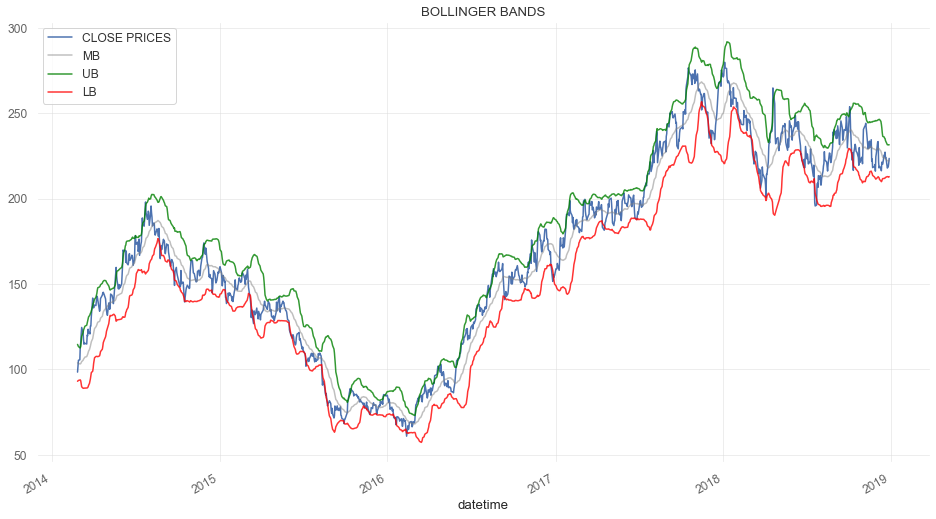

In [8]:
plt.figure(figsize=(16,9))
bb_signals['close'].plot(label = 'CLOSE PRICES')
bb_signals['mean'].plot(label = 'MB', color='grey', alpha=0.5)
bb_signals['upper_band'].plot(label = 'UB', color='green', alpha=0.8)
bb_signals['lower_band'].plot(label = 'LB', color='red', alpha=0.8)
plt.title('BOLLINGER BANDS')
plt.legend(loc = 'upper left')
plt.show()

## Plotting the signals

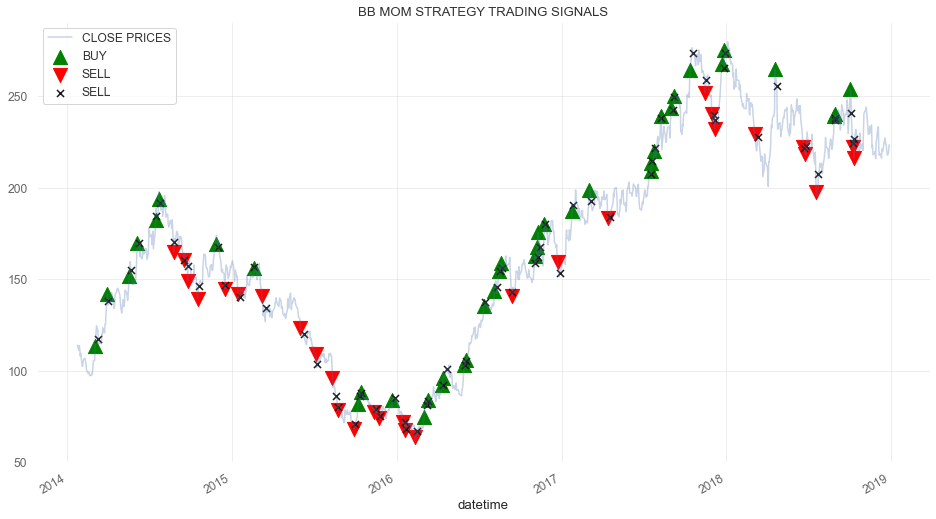

In [22]:
buy = bb_signals[bb_signals['1']==1]
sell = bb_signals[bb_signals['-1']==1]
exit = bb_signals[bb_signals['0']==1]

close = bb_signals.close
buy_price = close.loc[buy.index]
sell_price = close.loc[sell.index]
exit_price = close.loc[exit.index]

plt.figure(figsize=(16,9))
df.close.plot(label = 'CLOSE PRICES', alpha = 0.3)
plt.scatter(buy_price.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 50)
plt.scatter(sell_price.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 50)
plt.scatter(exit_price.index, exit_price, marker = 'x', color = 'k', label = 'SELL', s = 50)
plt.title('BB MOM STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

## Strategy Performance Report

In [18]:
strategy_result = vectorize_backtest(df, bb_signals)

In [20]:
strategy_result.head()

,PnL,returns,benchmark
datetime,,,
2014-02-26,-0.00,-0.000000,-0.004049
2014-02-28,0.00,0.000000,0.070630
2014-03-03,0.00,0.000000,0.002373
2014-03-04,8.00,0.075758,0.075758
2014-03-05,2.15,0.018926,0.018926


                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2014-02-26  2014-02-26
End Period          2018-12-28  2018-12-28
Risk-Free Rate      0.0%        0.0%
Time in Market      12.0%       100.0%

Cumulative Return   6,107.33%   126.21%
CAGR%               134.73%     18.38%

Sharpe              4.19        0.63
Sortino             30.67       0.94
Sortino/√2          21.68       0.67

Max Drawdown        -3.49%      -69.24%
Longest DD Days     62          922

Gain/Pain Ratio     22.85       0.11
Gain/Pain (1M)      inf         0.55

Payoff Ratio        3.42        3.42
Profit Factor       23.85       1.11
Common Sense Ratio  inf         1.25
CPC Index           74.01       1.91
Tail Ratio          inf         1.13
Outlier Win Ratio   18.16       3.44
Outlier Loss Ratio  2.12        1.65

MTD                 0.0%        -1.19%
3M                  16.76%      -9.86%
6M                  32.46%      2.57%
YTD                 61.21%     

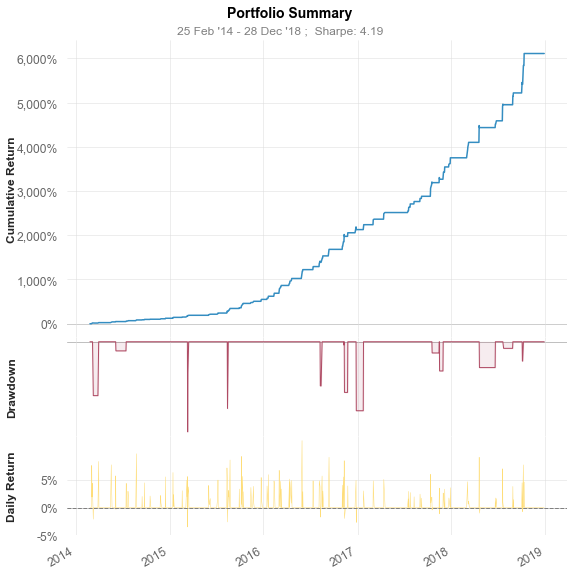

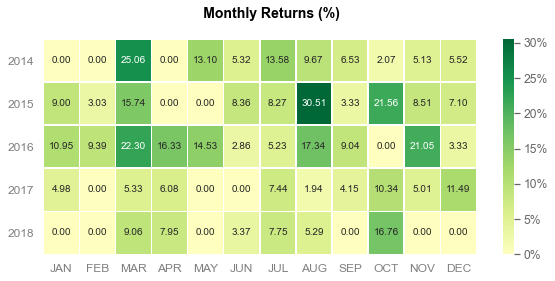

In [19]:
qs.reports.basic(strategy_result['returns'], strategy_result['benchmark'])